<a href="https://colab.research.google.com/github/ccarpenterg/introNLP/blob/master/03a_NLP_and_recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP and Recurrent Neural Networks

In the previous notebooks we used a deep neural network for classifying the IMDB movie reviews. But we had to resort to a trick: turning a sequence of vectors into a vector of fixed-length.

The present notebook introduces the recurrent neural networks, also known as RNNs. Recurrent neural networks have the ability to process sequences of variable length and eventually learn representations capturing the dependencies between the sequence's elements.

Formally $ X $ is a sequence of length $ T $ where $ X = \{x^{(1)}, x^{(2)},..., x^{(T)} \} $ and $ x_t \in \mathbb{R}^n $ is a vector input at time  $t$.

![RNN](https://user-images.githubusercontent.com/114733/78402628-48e80000-75d1-11ea-9620-286a3906a485.jpg)

## Sentiment Analysis of IMDB Movie Reviews

### Setting up the Training Environment

In [0]:
!pip install -q tensorflow-datasets==1.3.2

In [0]:
# load Tensorflow 2
%tensorflow_version 2.x
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import regularizers

import tensorflow_datasets as tfds
import numpy as np

print("Tensorflow version:", tf.__version__)
print("Tensorflow datasets version:", tfds.__version__)

Tensorflow version: 2.1.0
Tensorflow datasets version: 1.3.2


### IMDB Movie Reviews Dataset

In [0]:
train_validation_split = tfds.Split.TRAIN.subsplit([8, 2])

(train_validation_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (train_validation_split, tfds.Split.TEST),
    as_supervised=True,
    with_info=True
)

train_data, validation_data = train_validation_data

In [0]:
encoder = info.features['text'].encoder

## Preprocessing the Dataset with Padding

In [0]:
BUFFER_SIZE = 5000
BATCH_SIZE = 32

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_data))
)

validation_batches = (
    validation_data
    .padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(validation_data))
)

test_batches = (
    test_data
    .padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))
)

In [0]:
for batch_example, labels in train_batches.take(2):
    print("Batch shape:", batch_example.shape)
    print("Labels shape:", labels.shape)

Batch shape: (32, 1547)
Labels shape: (32,)
Batch shape: (32, 1572)
Labels shape: (32,)


## Sequence Processing with a Recurrent Neural Network

In [0]:
LAMBDA = 0.01

### Model 1: SubWord Embedding, 1 LSTM layer, 1 FC layer

In [0]:
model_v1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(
        units=64,
        activation='relu',
        kernel_regularizer=regularizers.l2(LAMBDA),
        bias_regularizer=regularizers.l2(LAMBDA)
    ),
    tf.keras.layers.Dense(
        units=1,
        activation='sigmoid',
        kernel_regularizer=regularizers.l2(LAMBDA),
        bias_regularizer=regularizers.l2(LAMBDA)
    )
])

model_v1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 561,089
Trainable params: 561,089
Non-trainable params: 0
_________________________________________________________________


### Model 2: SubWord Embedding, 1 Bidirectional LSTM layer, 1 FC layer

In [0]:
model_v2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(
        units=64,
        activation='relu',
        kernel_regularizer=regularizers.l2(LAMBDA),
        bias_regularizer=regularizers.l2(LAMBDA)
    ),
    tf.keras.layers.Dense(
        units=1,
        activation='sigmoid',
        kernel_regularizer=regularizers.l2(LAMBDA),
        bias_regularizer=regularizers.l2(LAMBDA)
    )
])

model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


**Embeding layer**



**LSTM layer**

Cell: 64 x 64 + 64 x 64 (weights) + 64 (biases) = 8,256 parameters

Update gate: 64 x 64 + 64 x 64 (weights) + 64 (biases) = 8,256 parameters

Forget gate: 64 x 64 + 64 x 64 (weights) + 64 (biases) = 8,256 parameters

Output gate: 64 x 64 + 64 x 64 (weights) + 64 (biases) = 8,256 parameters

**Bidirectional**

Forward LSTM: 33,024 parameters

Backward LSTM: 33,024 parameters

Total: 66,048 parameters

**FC layer**

The bidirectional layer outputs two activationn vectors, one for the forward LSTM and one for the backward LTSM, that gives us 128 activation units.

64 * 128 weigths + 64 biases = 8,256 parameters

**Dense classifier layer**

1 * 64 weights + 1 bias = 64 parameters

### Model 3: SubWord Embedding, 2 Bidirectional LSTM layers, 1 FC layer

In [0]:
model_v3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dense(
        units=64,
        activation='relu',
        kernel_regularizer=regularizers.l2(LAMBDA),
        bias_regularizer=regularizers.l2(LAMBDA)
    ),
    tf.keras.layers.Dense(
        units=1,
        activation='sigmoid',
        kernel_regularizer=regularizers.l2(LAMBDA),
        bias_regularizer=regularizers.l2(LAMBDA)
    )
])

model_v3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 697,025
Trainable params: 697,025
Non-trainable params: 0
_________________________________________________________________


### Model 4: SubWord Embedding, 2 Bidirectional LSTM layers, 1 Global Average Poling (hidden states), 1 FC layer

In [0]:
model_v4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(
        units=1,
        activation='sigmoid',
        kernel_regularizer=regularizers.l2(LAMBDA),
        bias_regularizer=regularizers.l2(LAMBDA)
    )
])

model_v4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 688,833
Trainable params: 688,833
Non-trainable params: 0
_________________________________________________________________


## Training the RNNs on the IMDB Reviews Dataset

In [0]:
EPOCHS = 10
VAL_STEPS = 30
results = {}

In [0]:
model_v1.compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(1e-4),
                 metrics=['accuracy'])

results['v1'] = model_v1.fit(train_batches, epochs=EPOCHS,
                             validation_data=validation_batches,
                             validation_steps=VAL_STEPS)

Epoch 1/10
625/625 [==============================] - 43s 69ms/step - loss: 1.1341 - accuracy: 0.5027 - val_loss: 0.9650 - val_accuracy: 0.4865
Epoch 2/10
625/625 [==============================] - 34s 55ms/step - loss: 0.8670 - accuracy: 0.5063 - val_loss: 0.7932 - val_accuracy: 0.4865
Epoch 3/10
625/625 [==============================] - 34s 54ms/step - loss: 0.7529 - accuracy: 0.5081 - val_loss: 0.7240 - val_accuracy: 0.4865
Epoch 4/10
625/625 [==============================] - 34s 54ms/step - loss: 0.7099 - accuracy: 0.5076 - val_loss: 0.7006 - val_accuracy: 0.4885
Epoch 5/10
625/625 [==============================] - 34s 54ms/step - loss: 0.6967 - accuracy: 0.5028 - val_loss: 0.6945 - val_accuracy: 0.4885
Epoch 6/10
625/625 [==============================] - 34s 54ms/step - loss: 0.6937 - accuracy: 0.5028 - val_loss: 0.6934 - val_accuracy: 0.4885
Epoch 7/10
625/625 [==============================] - 33s 53ms/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6932 - val_accuracy:

In [0]:
test_loss, test_accuracy = model_v1.evaluate(test_batches, verbose=0)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

Test Loss: 0.6931545062138297
Test Accuracy: 0.5


In [0]:
model_v2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

results['v2'] = model_v2.fit(train_batches, epochs=EPOCHS,
                             validation_data=validation_batches,
                             validation_steps=VAL_STEPS)

Epoch 1/10
625/625 [==============================] - 58s 92ms/step - loss: 1.2118 - accuracy: 0.5487 - val_loss: 0.9300 - val_accuracy: 0.6375
Epoch 2/10
625/625 [==============================] - 55s 88ms/step - loss: 0.6487 - accuracy: 0.8105 - val_loss: 0.6531 - val_accuracy: 0.7990
Epoch 3/10
625/625 [==============================] - 55s 89ms/step - loss: 0.4422 - accuracy: 0.8752 - val_loss: 0.3882 - val_accuracy: 0.8781
Epoch 4/10
625/625 [==============================] - 56s 89ms/step - loss: 0.3313 - accuracy: 0.9089 - val_loss: 0.3631 - val_accuracy: 0.8802
Epoch 5/10
625/625 [==============================] - 56s 89ms/step - loss: 0.2765 - accuracy: 0.9279 - val_loss: 0.3629 - val_accuracy: 0.8708
Epoch 6/10
625/625 [==============================] - 56s 90ms/step - loss: 0.2468 - accuracy: 0.9378 - val_loss: 0.3473 - val_accuracy: 0.8823
Epoch 7/10
625/625 [==============================] - 56s 90ms/step - loss: 0.2223 - accuracy: 0.9467 - val_loss: 0.3484 - val_accuracy:

In [0]:
test_loss, test_accuracy = model_v2.evaluate(test_batches, verbose=0)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

Test Loss: 0.43068612356434394
Test Accuracy: 0.8588799834251404


In [0]:
model_v3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

results['v3'] = model_v3.fit(train_batches, epochs=EPOCHS,
                             validation_data=validation_batches,
                             validation_steps=VAL_STEPS)

Epoch 1/10
625/625 [==============================] - 102s 163ms/step - loss: 1.1560 - accuracy: 0.6346 - val_loss: 0.7975 - val_accuracy: 0.7812
Epoch 2/10
625/625 [==============================] - 99s 158ms/step - loss: 0.6219 - accuracy: 0.8308 - val_loss: 0.5563 - val_accuracy: 0.8208
Epoch 3/10
625/625 [==============================] - 99s 158ms/step - loss: 0.4679 - accuracy: 0.8543 - val_loss: 0.4609 - val_accuracy: 0.8417
Epoch 4/10
625/625 [==============================] - 99s 158ms/step - loss: 0.3440 - accuracy: 0.8975 - val_loss: 0.4346 - val_accuracy: 0.8365
Epoch 5/10
625/625 [==============================] - 99s 159ms/step - loss: 0.2993 - accuracy: 0.9114 - val_loss: 0.4096 - val_accuracy: 0.8417
Epoch 6/10
625/625 [==============================] - 99s 159ms/step - loss: 0.2660 - accuracy: 0.9229 - val_loss: 0.4166 - val_accuracy: 0.8510
Epoch 7/10
625/625 [==============================] - 100s 159ms/step - loss: 0.2333 - accuracy: 0.9366 - val_loss: 0.4332 - val_

In [0]:
test_loss, test_accuracy = model_v3.evaluate(test_batches, verbose=0)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

Test Loss: 0.4889533096433753
Test Accuracy: 0.8298799991607666


In [0]:
model_v4.compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(1e-4),
                 metrics=['accuracy'])

results['v4'] = model_v4.fit(train_batches, epochs=EPOCHS,
                             validation_data=validation_batches,
                             validation_steps=VAL_STEPS)

Epoch 1/10
625/625 [==============================] - 103s 164ms/step - loss: 0.6812 - accuracy: 0.5815 - val_loss: 0.6955 - val_accuracy: 0.5771
Epoch 2/10
625/625 [==============================] - 99s 159ms/step - loss: 0.5289 - accuracy: 0.7500 - val_loss: 0.4557 - val_accuracy: 0.8396
Epoch 3/10
625/625 [==============================] - 99s 158ms/step - loss: 0.4183 - accuracy: 0.8394 - val_loss: 0.4799 - val_accuracy: 0.8042
Epoch 4/10
625/625 [==============================] - 99s 159ms/step - loss: 0.4097 - accuracy: 0.8404 - val_loss: 0.4222 - val_accuracy: 0.8448
Epoch 5/10
625/625 [==============================] - 99s 158ms/step - loss: 0.3640 - accuracy: 0.8672 - val_loss: 0.4134 - val_accuracy: 0.8313
Epoch 6/10
625/625 [==============================] - 99s 159ms/step - loss: 0.3414 - accuracy: 0.8766 - val_loss: 0.4220 - val_accuracy: 0.8562
Epoch 7/10
625/625 [==============================] - 100s 160ms/step - loss: 0.3391 - accuracy: 0.8759 - val_loss: 0.3884 - val_

In [0]:
test_loss, test_accuracy = model_v4.evaluate(test_batches, verbose=0)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

Test Loss: 0.3944591299709304
Test Accuracy: 0.8549200296401978


In [0]:
import matplotlib.pyplot as plt

def plot_metrics(training_results):

    training_dict = training_results.history

    acc = training_dict['accuracy']
    val_acc = training_dict['val_accuracy']
    loss = training_dict['loss']
    val_loss = training_dict['val_loss']

    epochs = range(1, EPOCHS + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

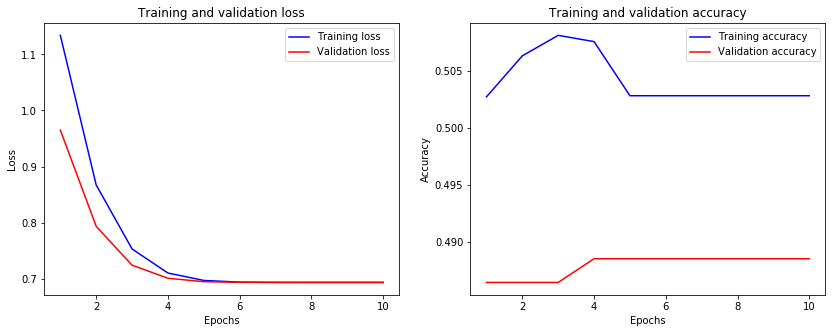

In [0]:
plot_metrics(results['v1'])

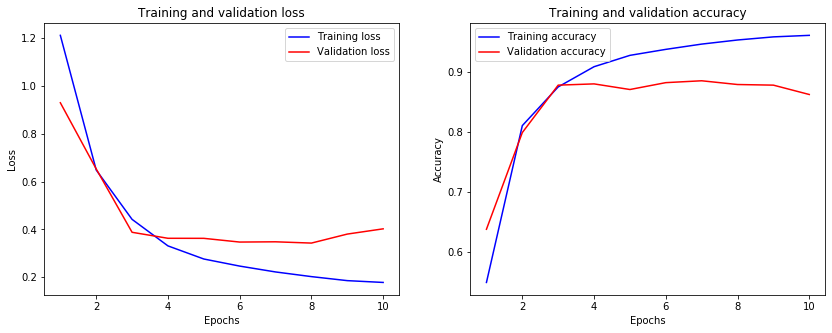

In [0]:
plot_metrics(results['v2'])

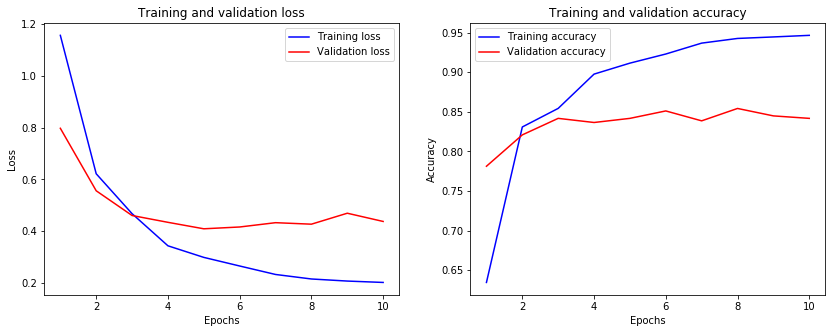

In [0]:
plot_metrics(results['v3'])

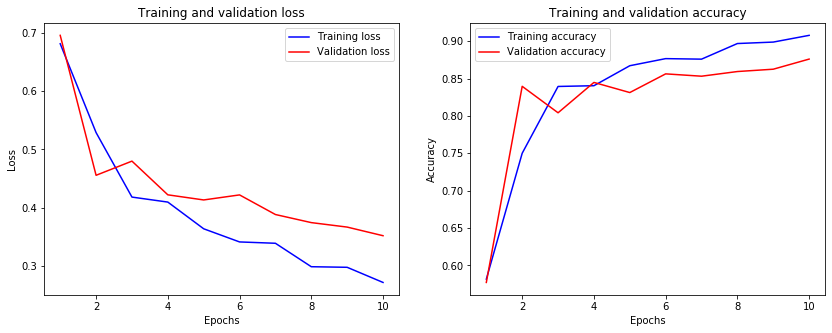

In [0]:
plot_metrics(results['v4'])

References

[1] RNNs and Language Models ([slides](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/slides/cs224n-2019-lecture06-rnnlm.pdf)) ([video](https://youtu.be/iWea12EAu6U)). CS224n: NLP with Deep Learning (2019), Stanford University

[2] Vanishing Gradients and Fancy RNNs ([slides](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/slides/cs224n-2019-lecture07-fancy-rnn.pdf)) ([video](https://youtu.be/QEw0qEa0E50)). CS224n: NLP with Deep Learning (2019), Stanford University

[3] Deep Learning ([online version](https://www.deeplearningbook.org/)). Ian Goodfellow, Yoshua Bengio, AAron Courville